In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
# %cp '/content/drive/MyDrive/AIsec/ass-1/simpleMNIST/AA_best_model_20250226_041514.pth' '/content/drive/MyDrive/AIsec/ass-2/model'

In [3]:
%cd /content/drive/MyDrive/AIsec/ass-2/

/content/drive/MyDrive/AIsec/ass-2


In [4]:
%ls

cfg.py                              fgsm_epsilon_0.05.png  filters_inception_branch1.png
data/                               fgsm_epsilon_0.15.png  filters_inception_branch2.png
data_tmp/                           fgsm_epsilon_0.1.png   filters_inception_branch3.png
feature_maps_Conv1.png              fgsm_epsilon_0.25.png  filters_inception_branch4.png
feature_maps_Inception-Branch1.png  fgsm_epsilon_0.2.png   main.ipynb
feature_maps_Inception-Branch2.png  fgsm_epsilon_0.3.png   model/
feature_maps_Inception-Branch3.png  fgsm_epsilon_0.png     __pycache__/
feature_maps_Inception-Branch4.png  figures/               src/
fgsm_accuracy_vs_epsilon.png        filters_conv1.png


In [5]:

from src.data import MNISTDataLoader
from src.test import test
from src.evaluate import ModelPerformance
from cfg import cfg
import torch
import multiprocessing
import itertools
import os
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import sys
import matplotlib.pyplot as plt

In [6]:

torch.manual_seed(42)

In [7]:
def plot_metrics(output_metrics, base_filename=None):
    """Plot Loss, Accuracy, and Perplexity in a single figure with subplots."""

    # plot out put metrics
    num_plots = 2

    fig, ax = plt.subplots(1, num_plots, figsize=(15, 5))

    ax[0].plot(output_metrics['train_losses'], label='Training Loss')
    ax[0].set_title('Loss Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot Accuracy
    ax[1].plot(output_metrics['train_accs'], label='Training Accuracy')

    ax[1].set_title('Accuracy Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()


    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    file_path = os.path.join('figures', base_filename + '_metrics.png')

    plt.savefig(file_path)
    plt.show()

<ipython-input-8-73ee7734b9d4>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path,map_location=device)


Test Accuracy: 0.9664


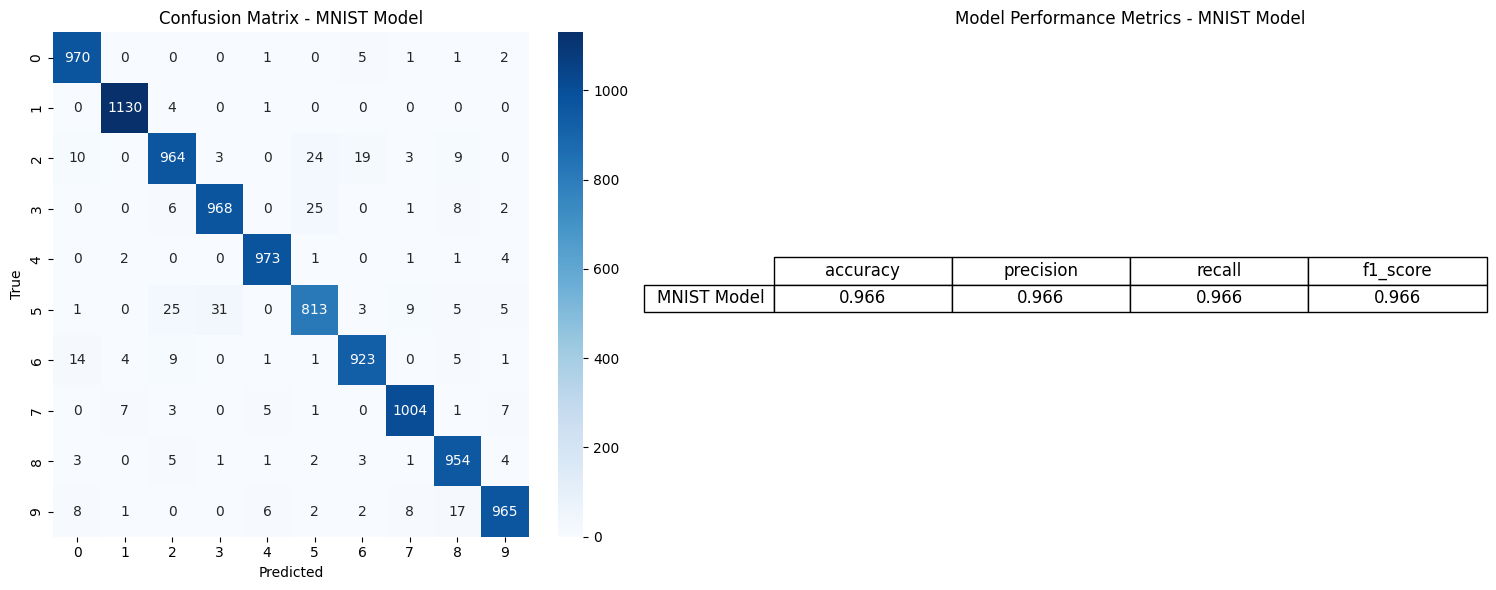

In [8]:

bs = 128
lr = 3e-2
#Data loader
data_loader = MNISTDataLoader(bs,cfg['num_workers'])
train_data, test_data = data_loader.get_data_loaders()
model_path = '/content/drive/MyDrive/AIsec/ass-2/model/AA_best_model_20250226_041514.pth'


device='cuda' if torch.cuda.is_available() else 'cpu'

checkpoint = torch.load(model_path,map_location=device)
model = checkpoint['model'].to(device)


#test
test_acc, y_pred,y_true = test(model, test_data, device)
print(f'Test Accuracy: {test_acc:.4f}')

#confusion matrix
mp = ModelPerformance()
fig_name = f"{bs}_lr_{lr}.PNG"
mp.plot_comparison(
y_true=y_true,
y_pred=y_pred,
model_name="MNIST Model",
class_names=[str(i) for i in range(10)],
fig_name=fig_name)

In [9]:
def visualize_feature_maps(model, img, device):
    """
    Visualize feature maps from convolutional layers in the model.

    Args:
        model: The neural network model
        img: A single input image tensor
        device: The device (CPU or GPU)
    """
    # image to the right device
    img = img.to(device)

    # Store outputs
    layer_outputs = []

    def hook_fn(module, input, output):
        layer_outputs.append(output)

    # Register hooks for each layer you want to visualize
    model.conv1.register_forward_hook(hook_fn)
    model.inception.branch1.register_forward_hook(hook_fn)
    model.inception.branch2.register_forward_hook(hook_fn)
    model.inception.branch3.register_forward_hook(hook_fn)
    model.inception.branch4[1].register_forward_hook(hook_fn)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(img)

    # Layer names for visualization
    layer_names = ['Conv1', 'Inception-Branch1', 'Inception-Branch2', 'Inception-Branch3', 'Inception-Branch4']

    # Plot feature maps
    for idx, (fmap, name) in enumerate(zip(layer_outputs, layer_names)):
        # Get feature maps from first image in batch
        fmap = fmap[0].detach().cpu().numpy()

        plt.figure(figsize=(12, 8))
        num_channels = min(16, fmap.shape[0])

        for i in range(num_channels):
            plt.subplot(4, 4, i+1)
            plt.imshow(fmap[i], cmap='gray')
            plt.axis('off')

        plt.suptitle(f'Feature Maps: {name}')
        plt.tight_layout()
        plt.savefig(f'feature_maps_{name}.png')
        plt.show()

In [11]:
#Plot the original and adversarial images side-by-side to highlight the perturbations.
def visualize_side_by_side(adv_images,actual_pred,adv_pred, epsilon):
    n= len(actual_pred)
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        #[0.485], std=[0.229]
        plt.imshow((adv_images[i]*0.483 +0.22).cpu().squeeze(), cmap='gray')
        plt.title("{} → {}".format(actual_pred[i], adv_pred[i]),
          fontdict={'color': 'green' if actual_pred[i] == adv_pred[i] else 'black'})


        plt.axis('off')
        plt.figtext(0.3, 0.01, f'Epsilon: {epsilon}', fontsize=15, ha='center')
    plt.show(block=True)

#viulize only the first 5 images on both of the last batrch of test data
def plot_accs(accs, type_attack):
    plt.figure(figsize=(12,5))
    plt.plot(epsilons, accs, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Accuracy vs Epsilon for {type_attack}")
    plt.xlabel(f"Epsilon--> {type_attack}")
    plt.ylabel(f"Accuracy---> {type_attack}")
    plt.show()




In [12]:

def pgd_attack(model,criterion,test_loader,epsilon=0.3, step_size=0.004, iters=40):
    '''
    Generates adversarial examples using the Projected Gradient Descent (PGD) method
    '''
    # init
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        orig_images = images.data

        #iterations
        for i in range(iters):
            images.requires_grad = True
            orig_outputs = model(images)

            model.zero_grad()
            loss = criterion(orig_outputs, labels)
            loss.backward()

            #pertub the images
            adv_images = images + step_size*images.grad.sign()
            eta = torch.clamp(adv_images - orig_images, min=-epsilon, max=epsilon)
            images = torch.clamp(orig_images + eta, min=0, max=1).detach_()


        adv_outputs = model(images)
        _,orig_predicted = torch.max(model(orig_images).data, 1)
        _, adv_predicted = torch.max(adv_outputs.data, 1)
        total += labels.size(0)
        correct += (adv_predicted == labels).sum().item()


    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

    return acc,images[:5],orig_predicted[:5], adv_predicted[:5], orig_images[2].unsqueeze(0)


def noise_attack(test_loader, epsilon=0.1):
    '''
    Generates adversarial examples by adding  Gaussian distribution noise to the input images

    Args:
        images: Input tensor of images (batch_size, channels, height, width)
        epsilon: Strength of the noise attack (default: 0.1)

    Returns:
        Perturbed images with Gaussian noise added
    '''
    model.eval()

    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)

        labels = labels.to(device)

        #denormilize the image first
        denorm_images = denorm(images)

        # Add Gaussian noise to the images
        gaus_noise = torch.randn_like(denorm_images) * epsilon
        perturbed_imgs = denorm_images + gaus_noise
        perturbed_imgs = torch.clamp(perturbed_imgs,0,1)

        #normalize back
        perturbed_imgs = norm(perturbed_imgs)

        # do prediction with the perturbed image
        adv_outputs = model(perturbed_imgs)
        _, adv_predicted = torch.max(adv_outputs.data, 1)
        total += labels.size(0)
        correct += (adv_predicted == labels).sum().item()



    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")


    return accuracy, perturbed_imgs[:5],labels[:5], adv_predicted[:5],images[2].unsqueeze(0)

def norm(perturbed_data,mean=[0.485], std=[0.229]):
  return transforms.Normalize(mean=[0.485], std=[0.229])(perturbed_data)


def denorm(batch, mean=[0.485], std=[0.229]):
    if isinstance(mean, list):
      mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)
    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def fgsm_attack(model, criterion, test_loader, epsilon, device):
    '''
    Generates adversarial examples using the Fast Gradient Sign Method (FGSM)
    Args:
        images: Input tensor of images (batch_size, channels, height, width)
        epsilon: Strength of the noise attack
        data_grad: Gradient of the loss with respect to the input images
    '''

    model.eval()
    correct = 0
    total = 0
    for images, labels in test_data:
        images = images.to(device)
        labels = labels.to(device)

        images.requires_grad = True # to get gradients

        # forward pass
        orig_outputs = model(images)

        model.zero_grad()
        loss = criterion(orig_outputs, labels)
        loss.backward()

        data_grad = images.grad.data


        # First denormalize the original images
        denorm_images = denorm(images)

        # Apply FGSM: perturbed_image = image + epsilon * sign(data_grad)
        perturbed_images = denorm_images + epsilon * data_grad.sign()
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        # Renormalize the perturbed images
        perturbed_images_norm = norm(perturbed_images)
        #print(perturbed_images_norm.max())

        adv_outputs = model(perturbed_images_norm)
        _,orig_predicted = torch.max(orig_outputs.data, 1)
        _, adv_predicted = torch.max(adv_outputs.data, 1)
        total += labels.size(0)
        correct += (adv_predicted == labels).sum().item()


    accuracy = 100 * correct / total


    print(f"Accuracy: {accuracy:.2f}%")


    return accuracy, perturbed_images[:5],orig_predicted[:5], adv_predicted[:5], images[2].unsqueeze(0)

#For different epsilon the accuracy and  image visualizations

Accuracy: 96.64%


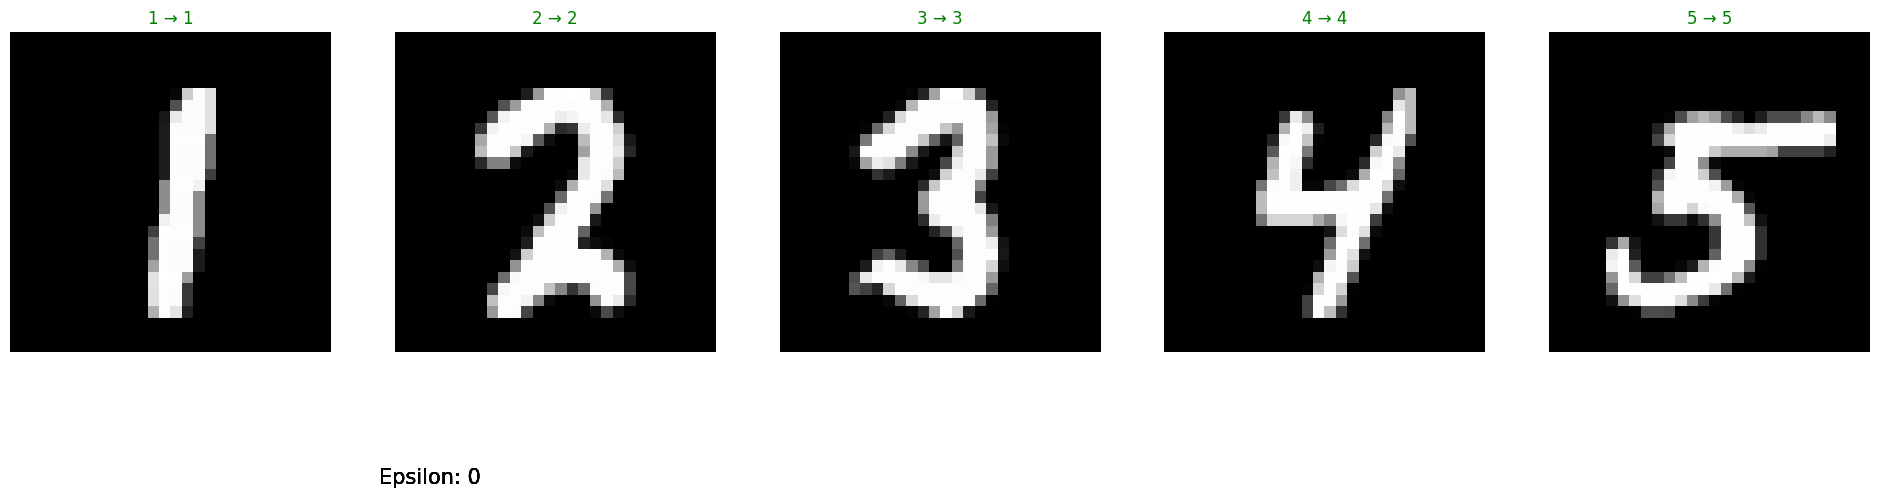

Accuracy: 71.83%


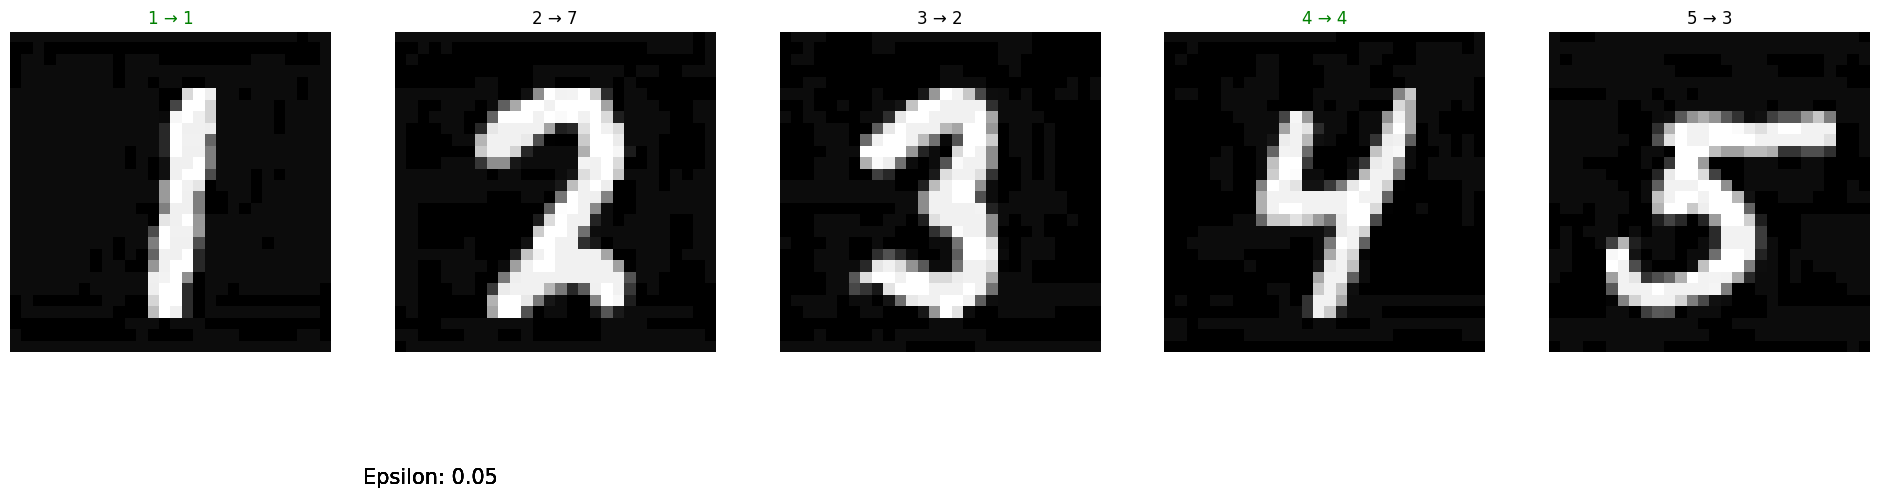

Accuracy: 26.98%


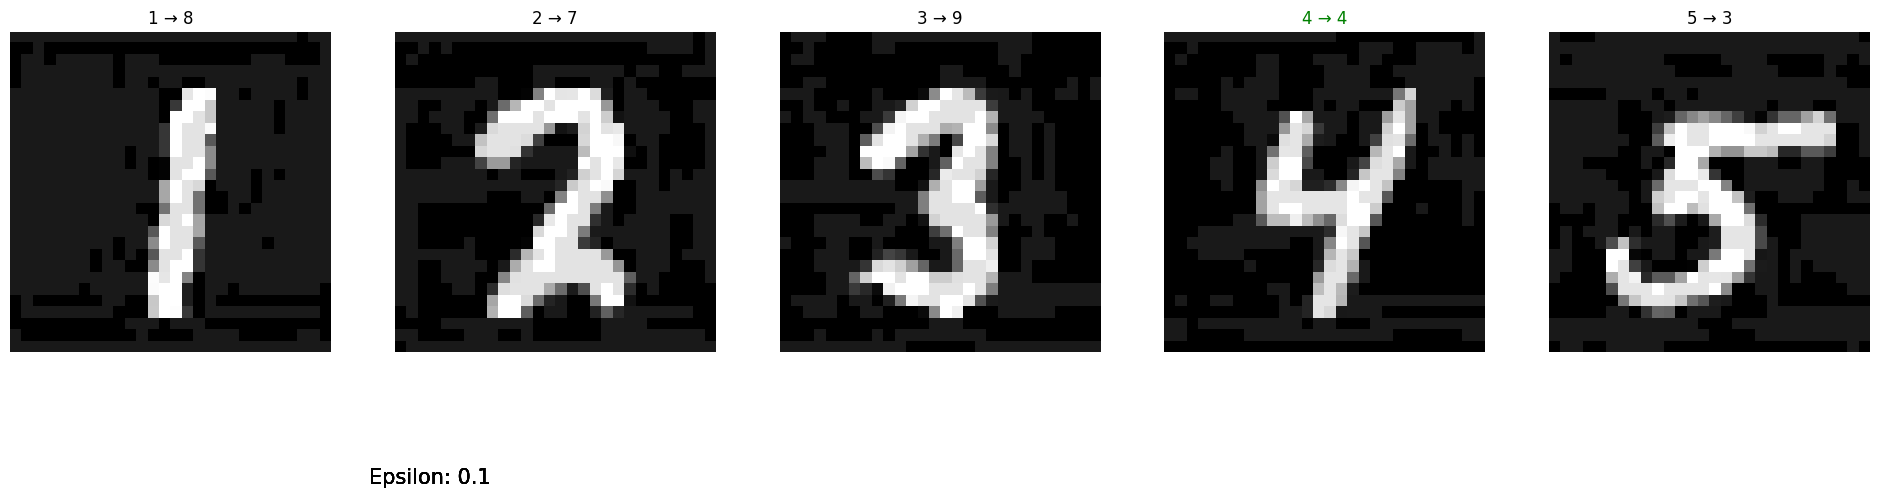

Accuracy: 11.28%


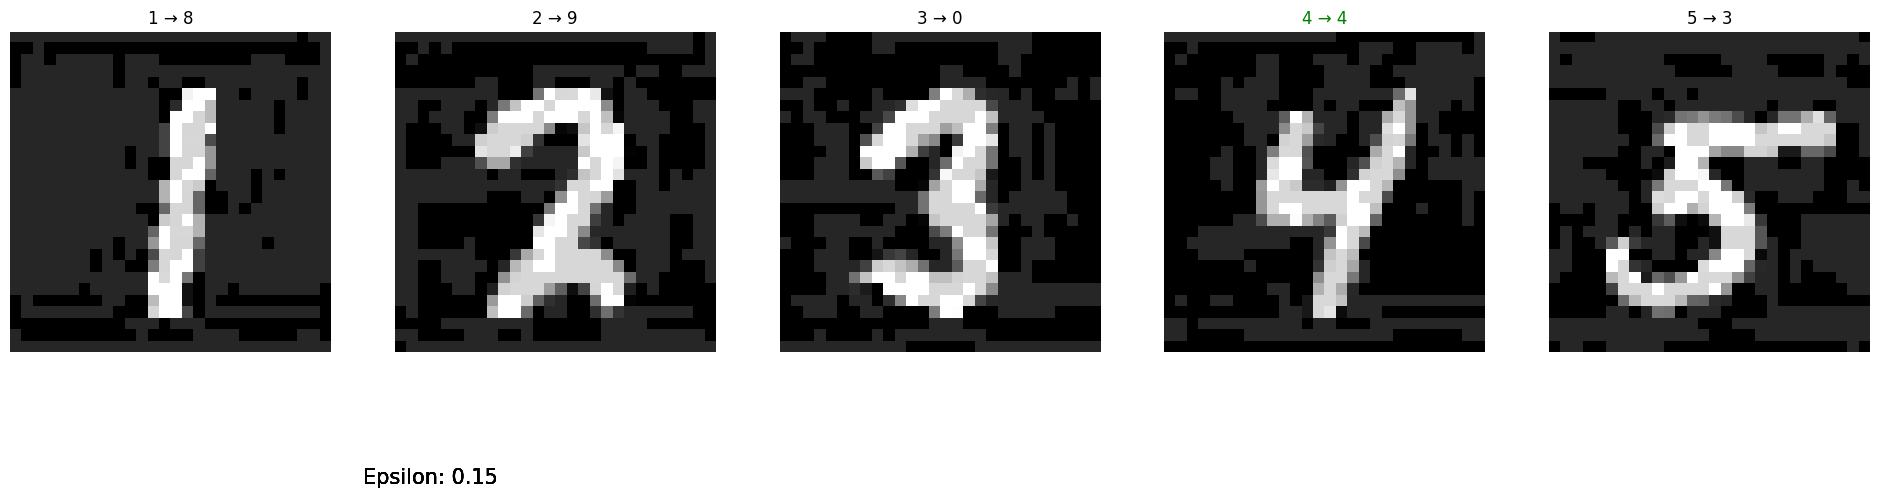

Accuracy: 7.64%


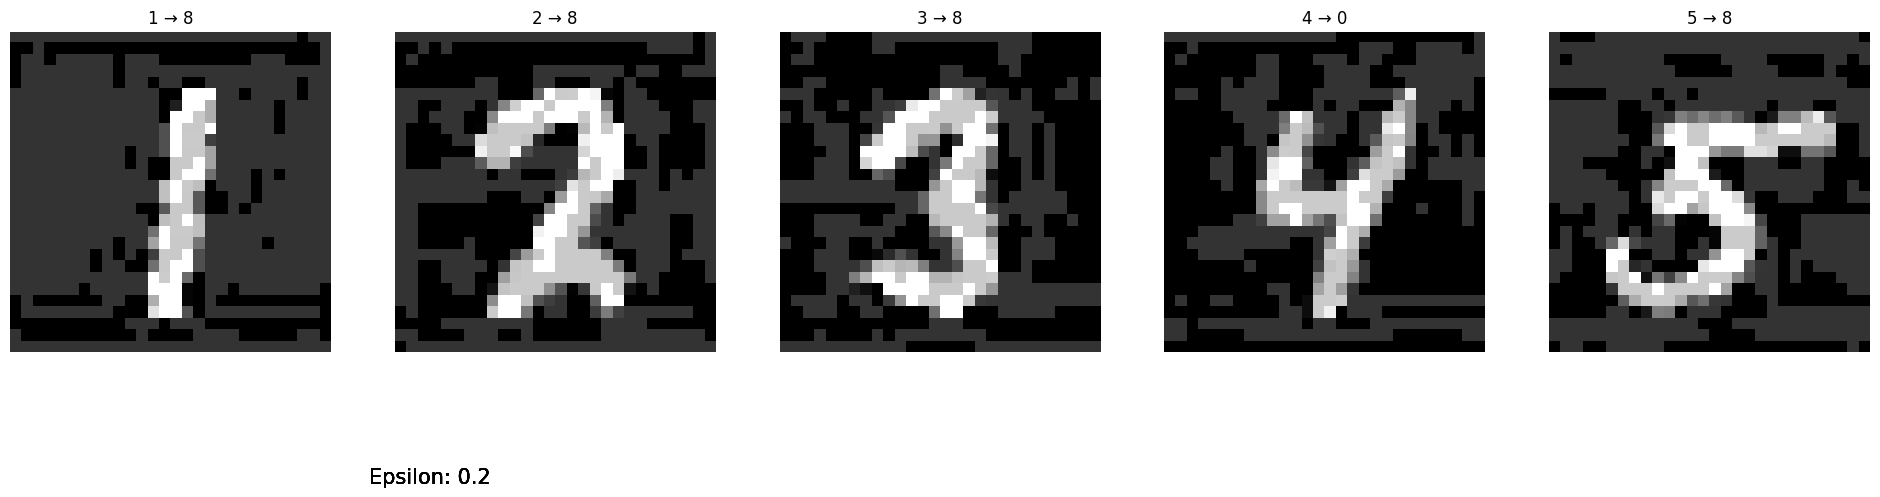

Accuracy: 8.33%


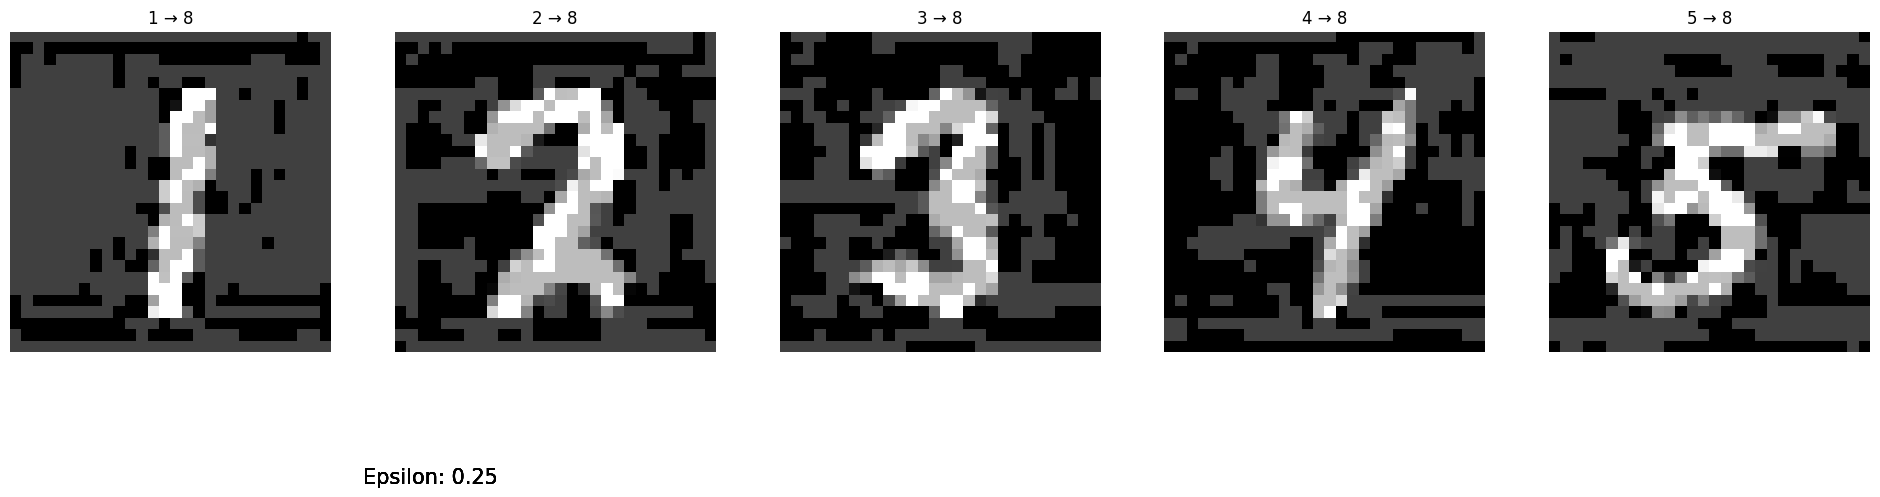

Accuracy: 9.17%


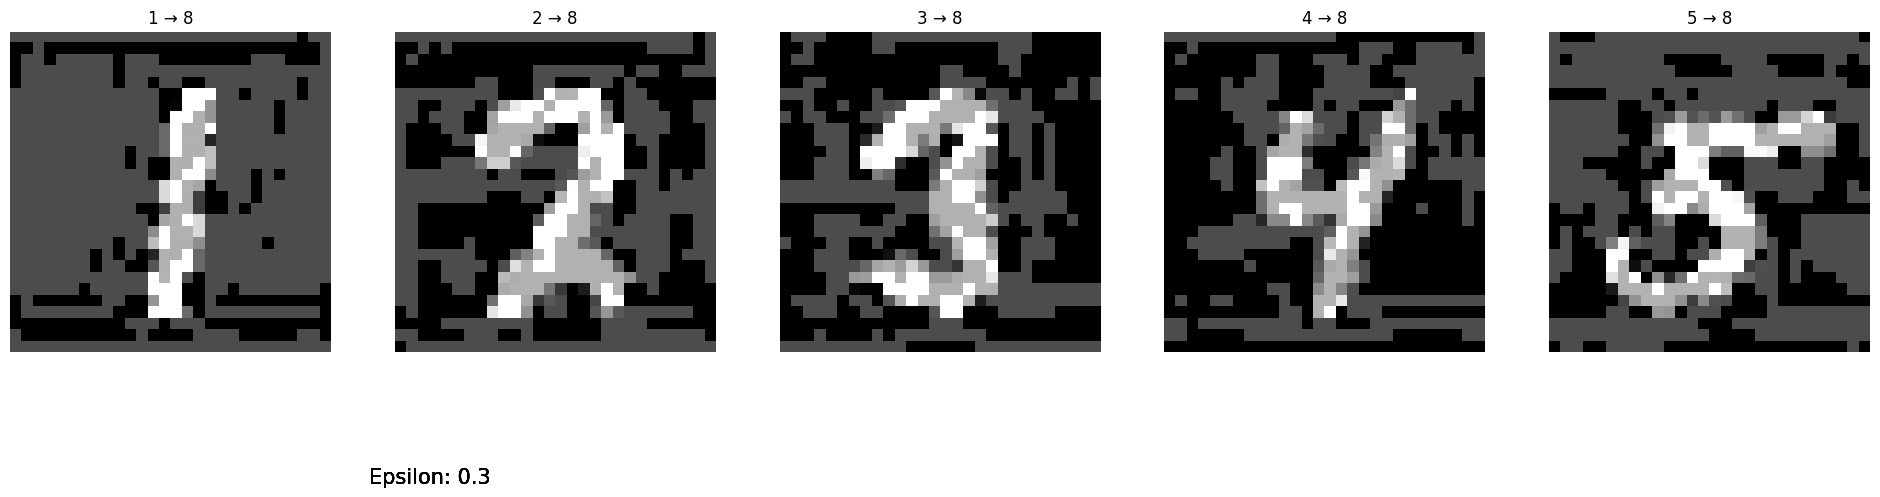

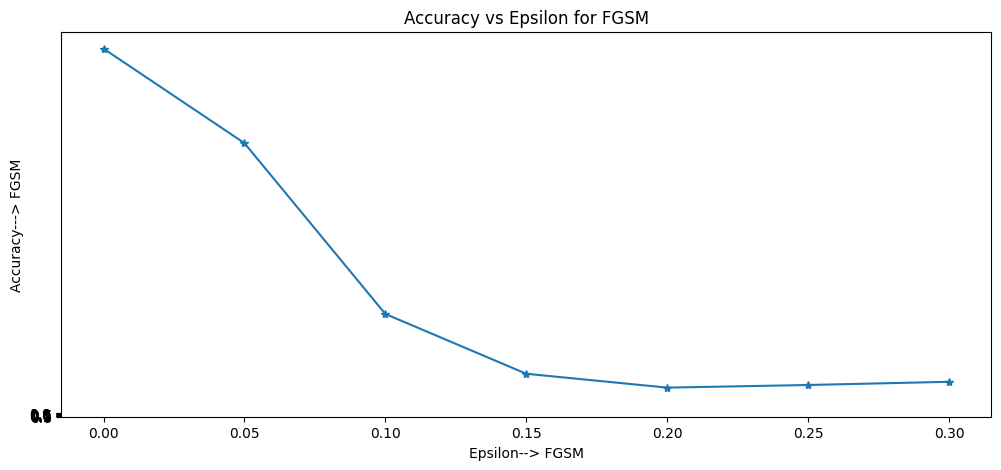

In [13]:
# FGSM
accs = []
adv_exs = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epsilons = [0, .05, .1, .15, .2, .25, .3]
criterion = nn.CrossEntropyLoss()
for epsilon in epsilons:
  acc,adv_img, n_pred, adv_pred,img = fgsm_attack(model, criterion, test_data, epsilon, device)
  accs.append(acc)
  visualize_side_by_side(adv_img.detach(), n_pred.detach(), adv_pred.detach(),epsilon)

plot_accs(accs, "FGSM")


#Feature map before attack


Accuracy: 94.40%


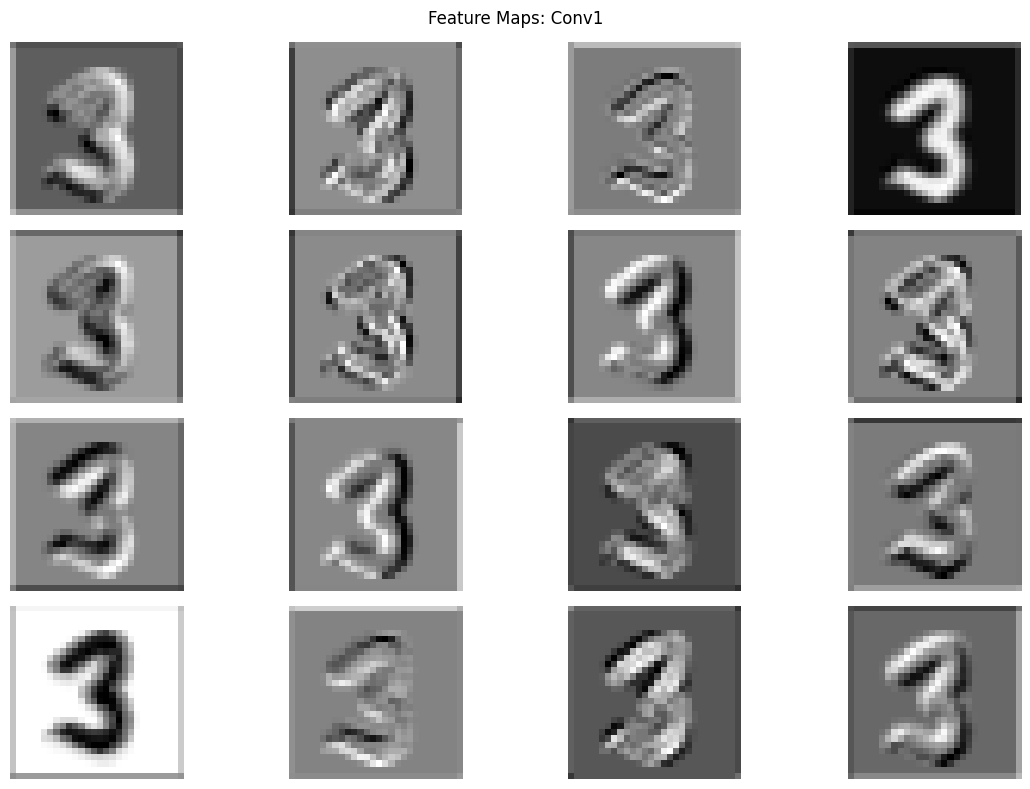

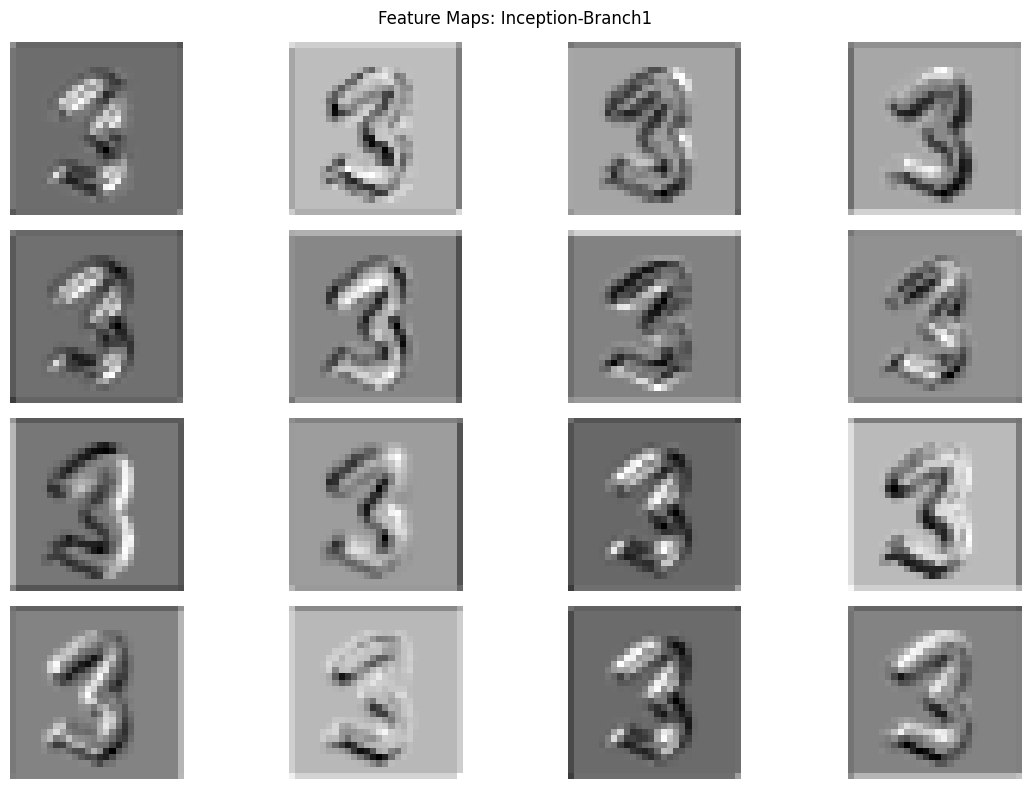

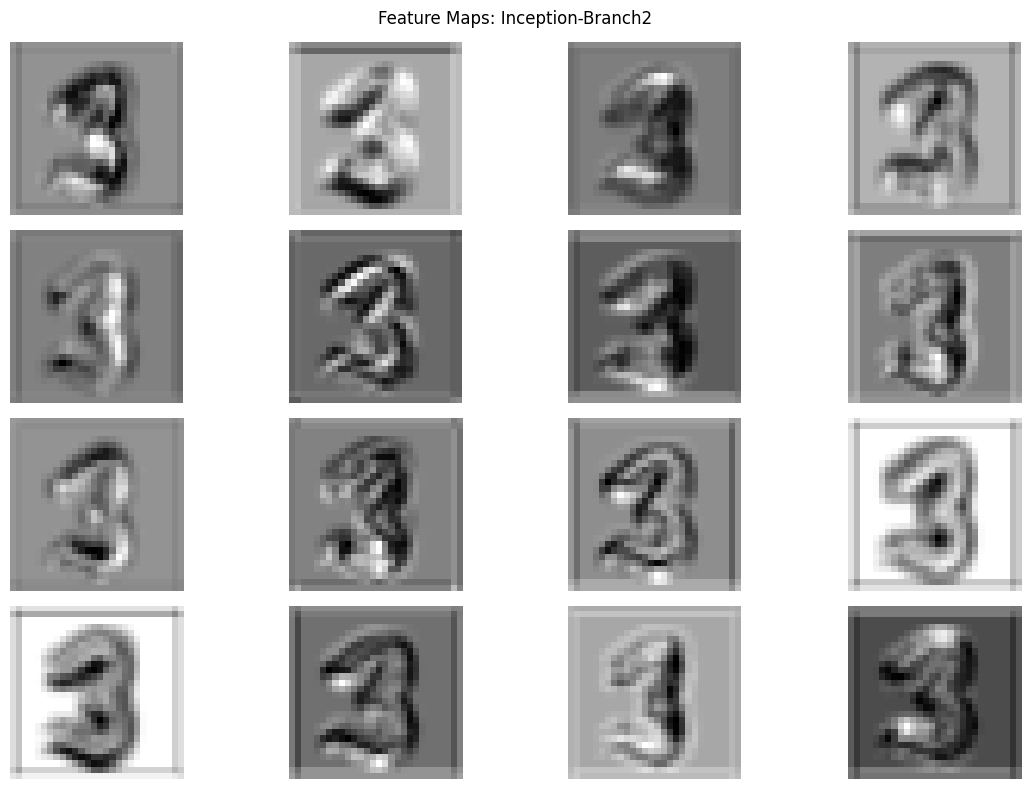

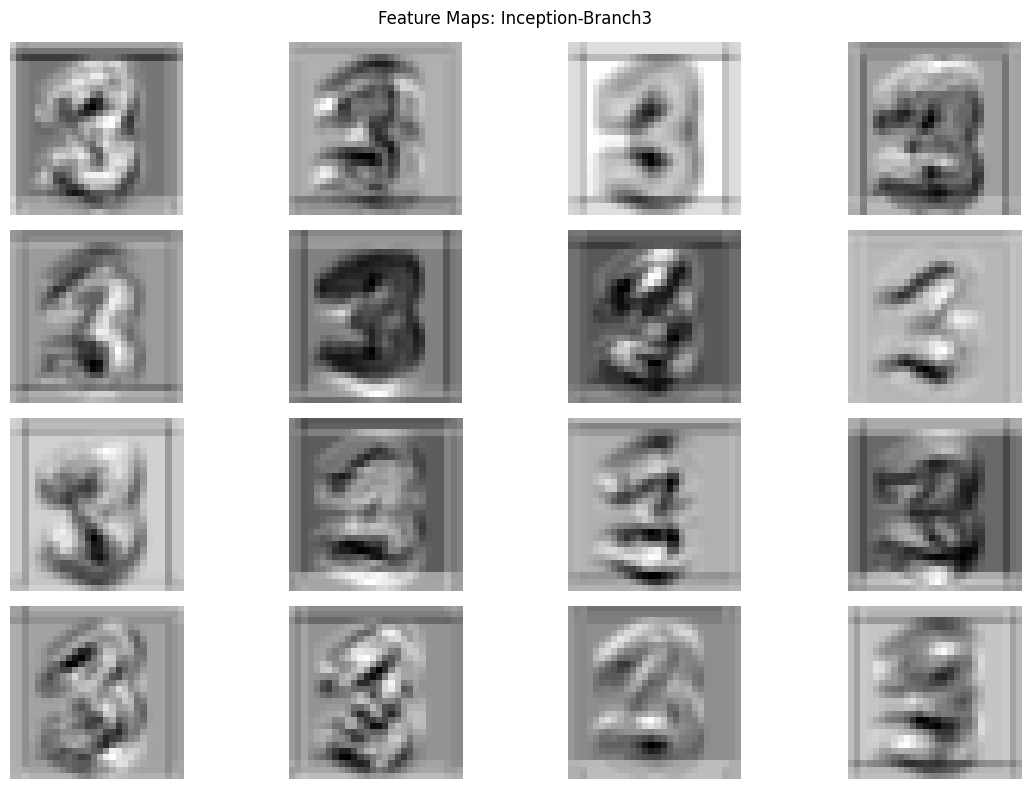

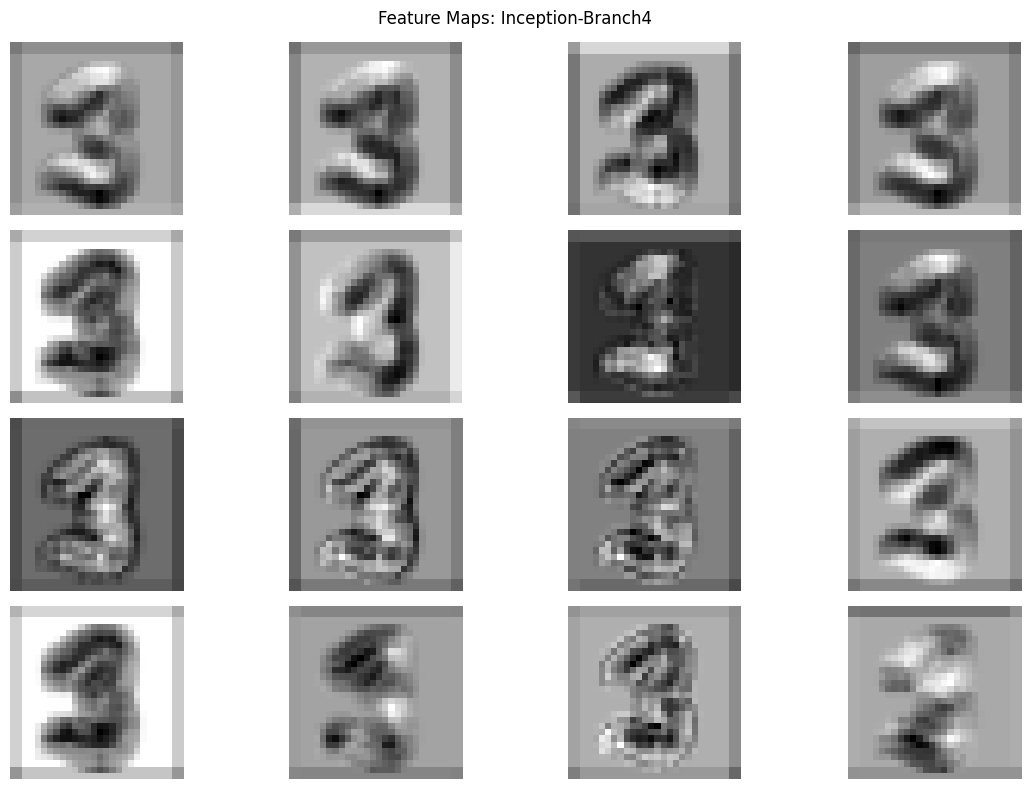

In [14]:
acc,adv_img, n_pred, adv_pred,img = fgsm_attack(model, criterion, test_data, 0.01, device)
visualize_feature_maps(model, img, device)


#After Attack with epsilon=0.3

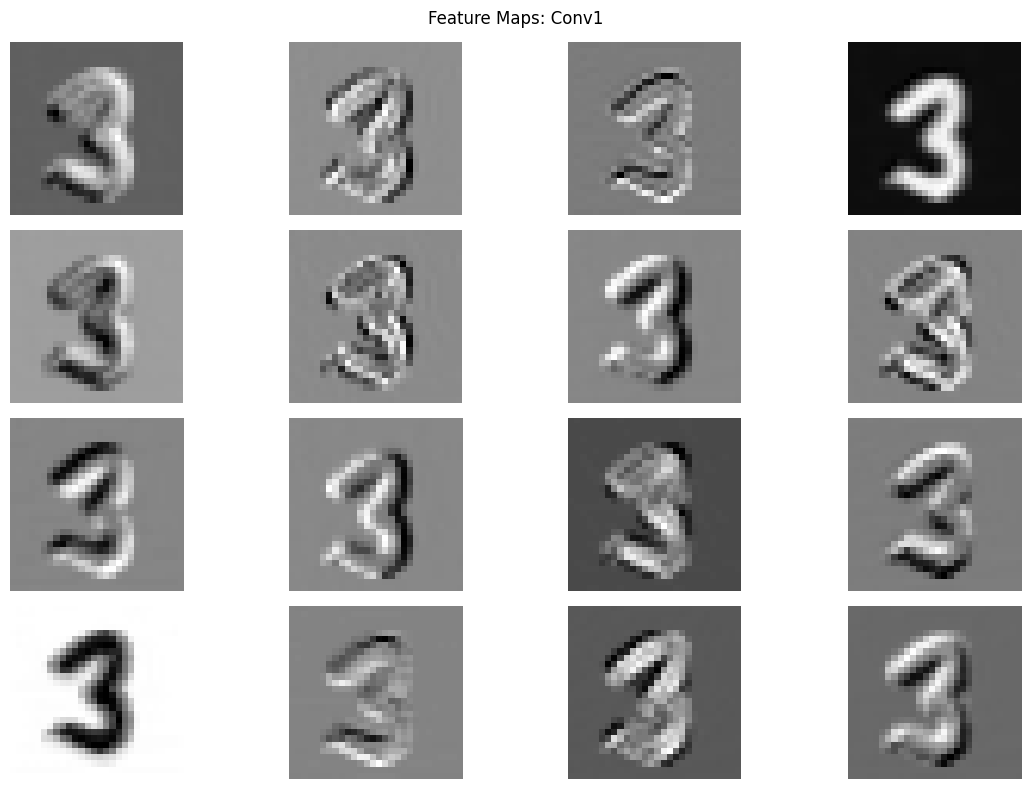

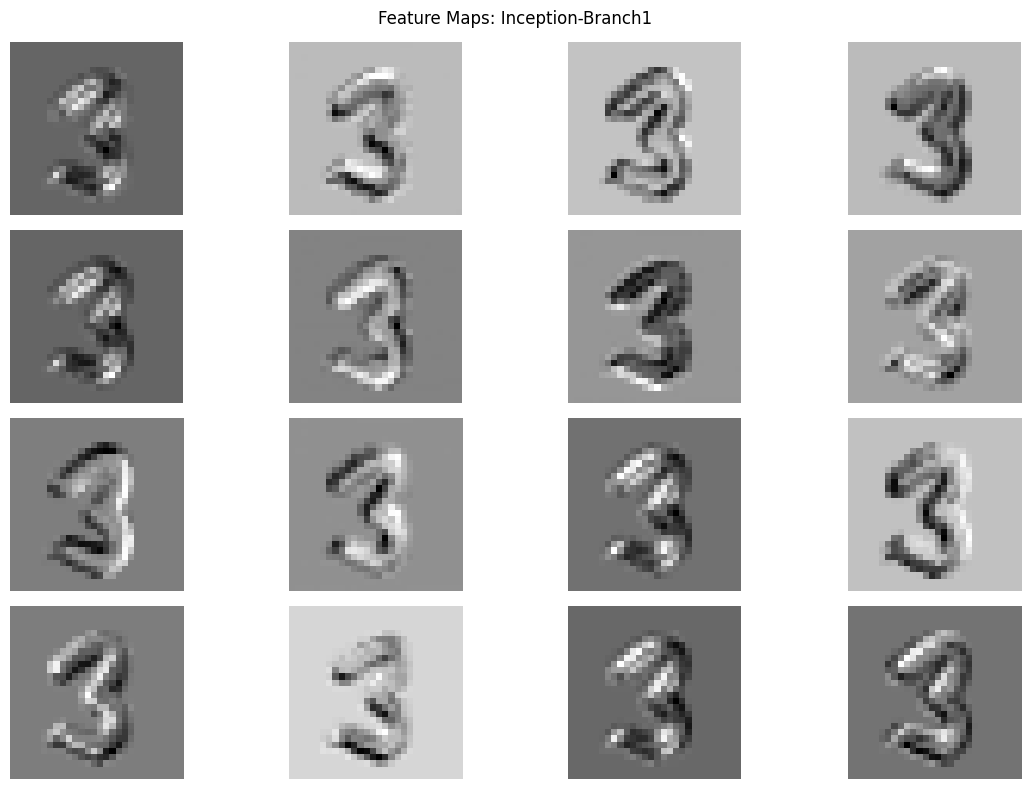

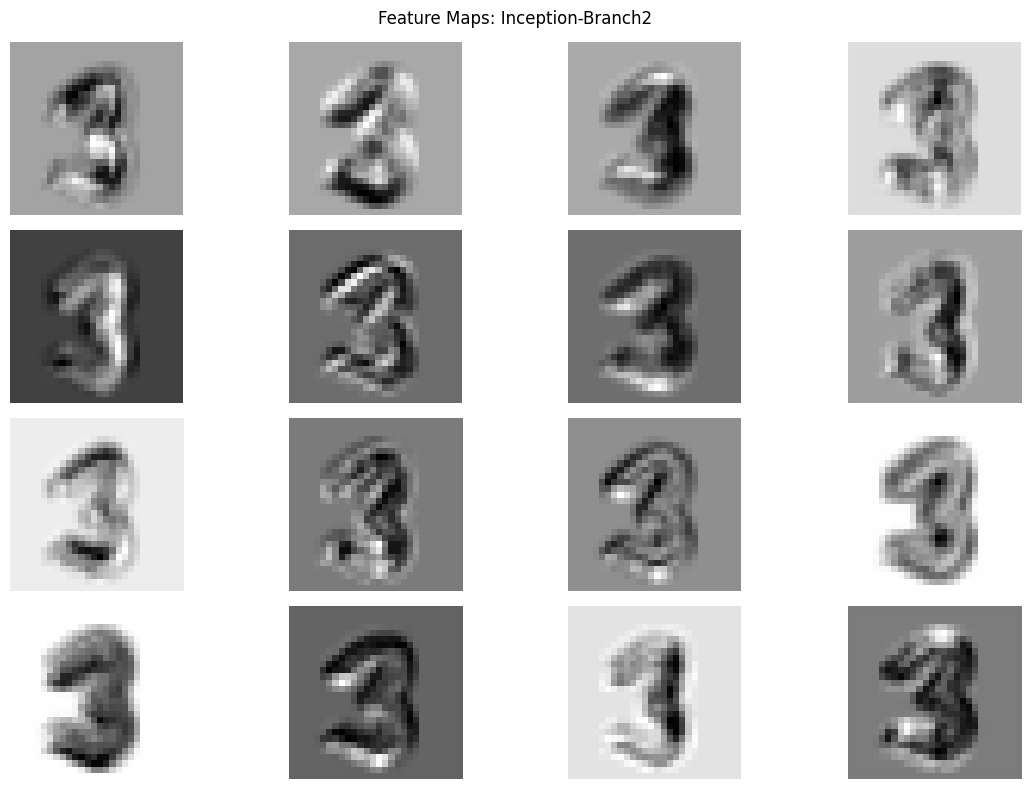

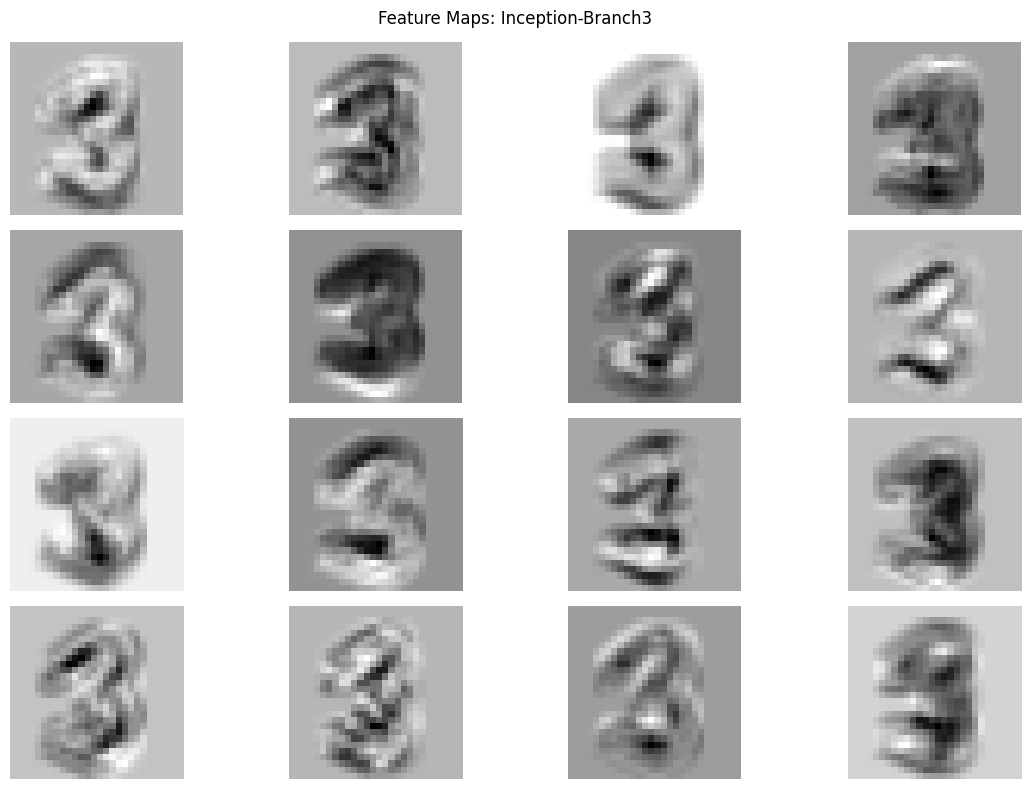

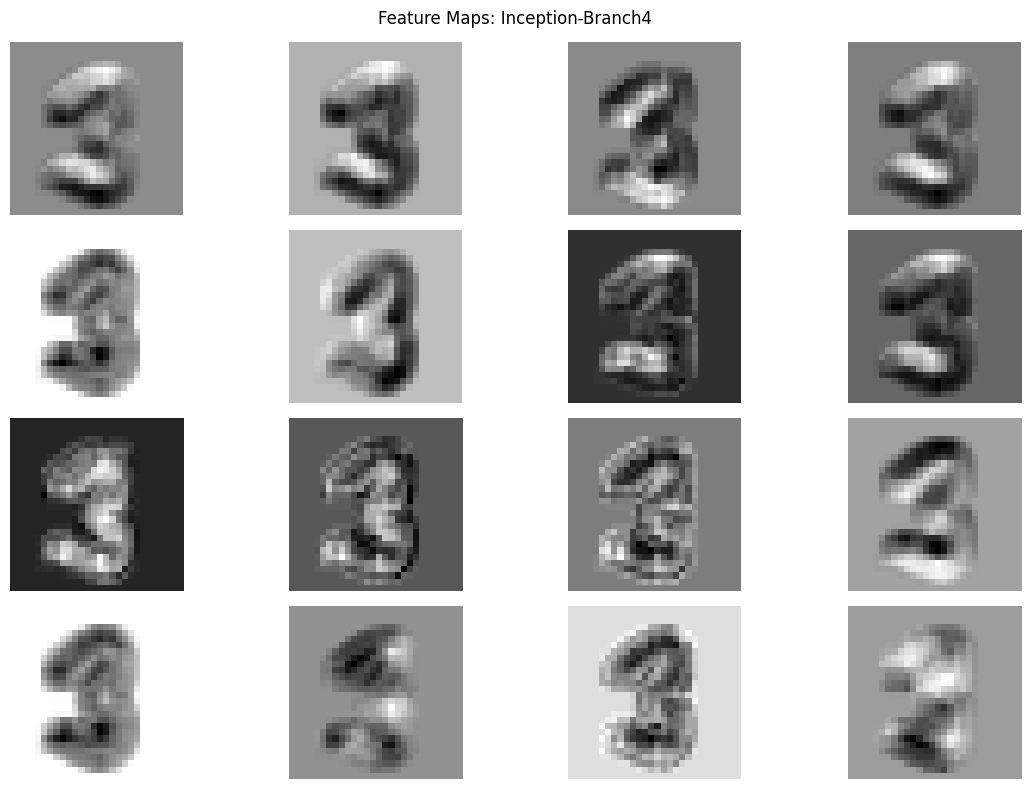

In [15]:
visualize_feature_maps(model,adv_img[2].unsqueeze(0), device)

Accuracy: 96.64%


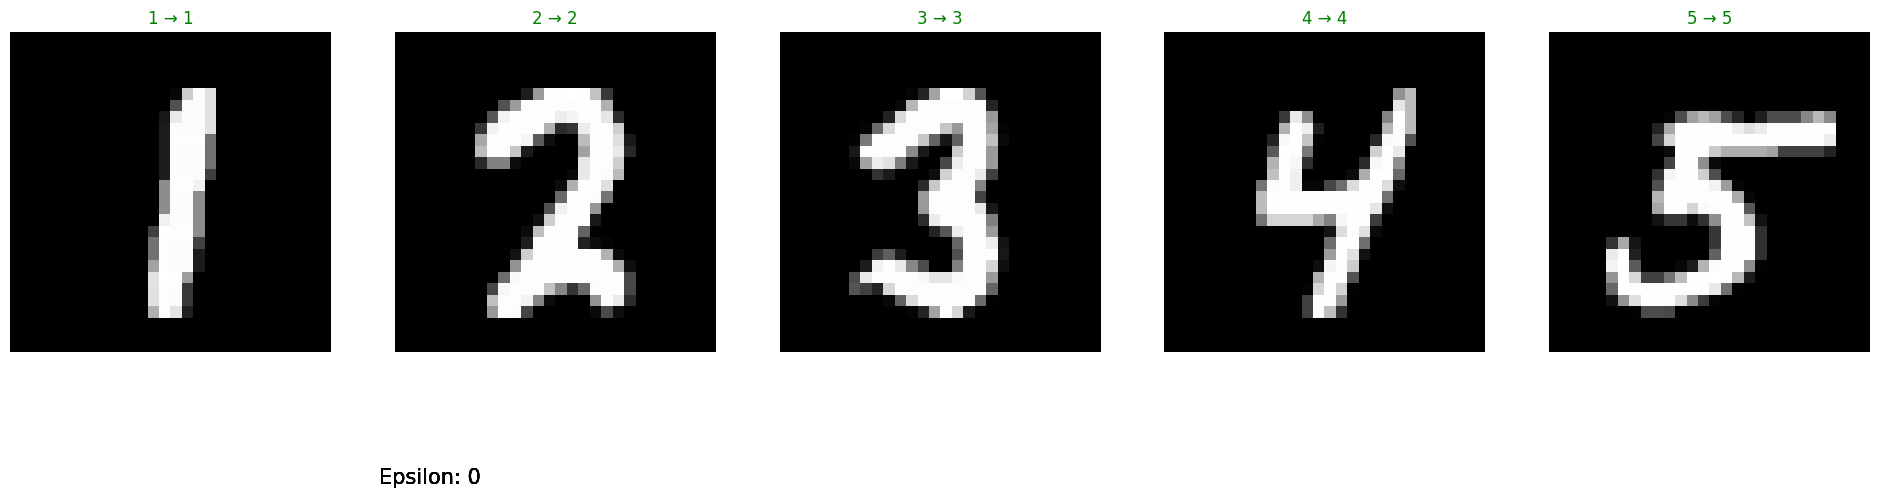

Accuracy: 95.69%


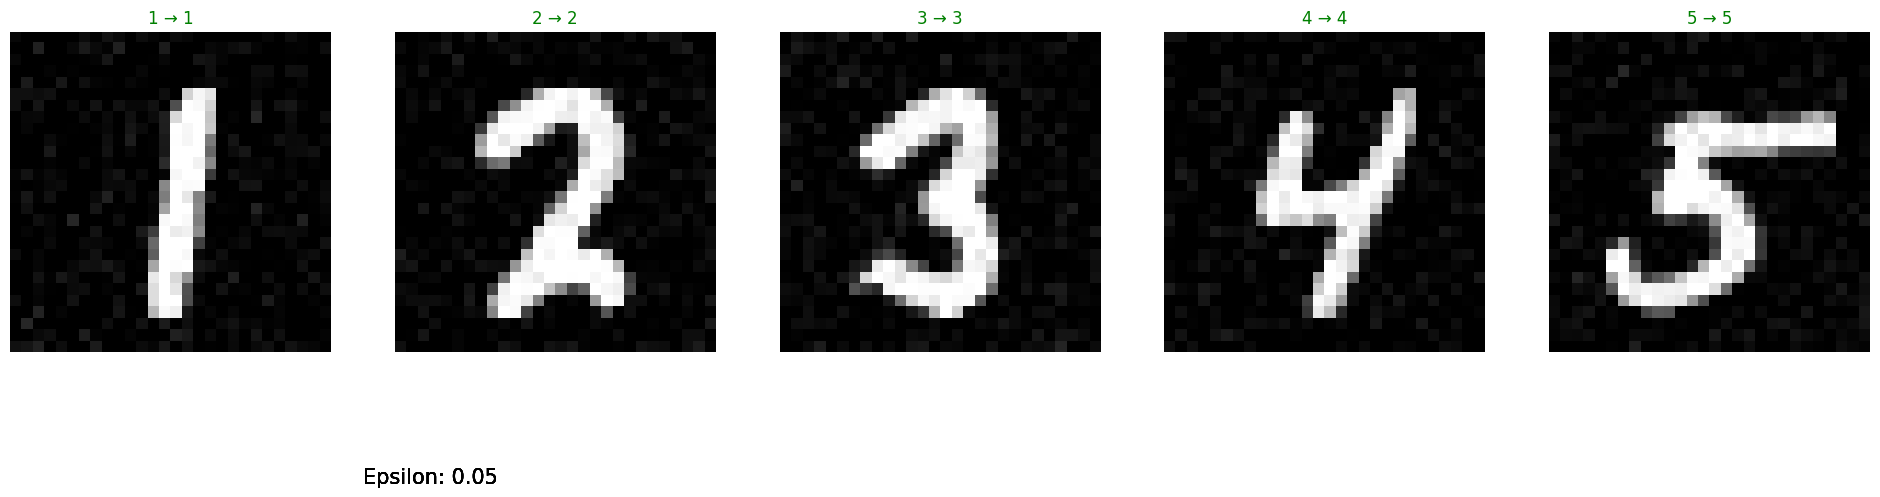

Accuracy: 52.56%


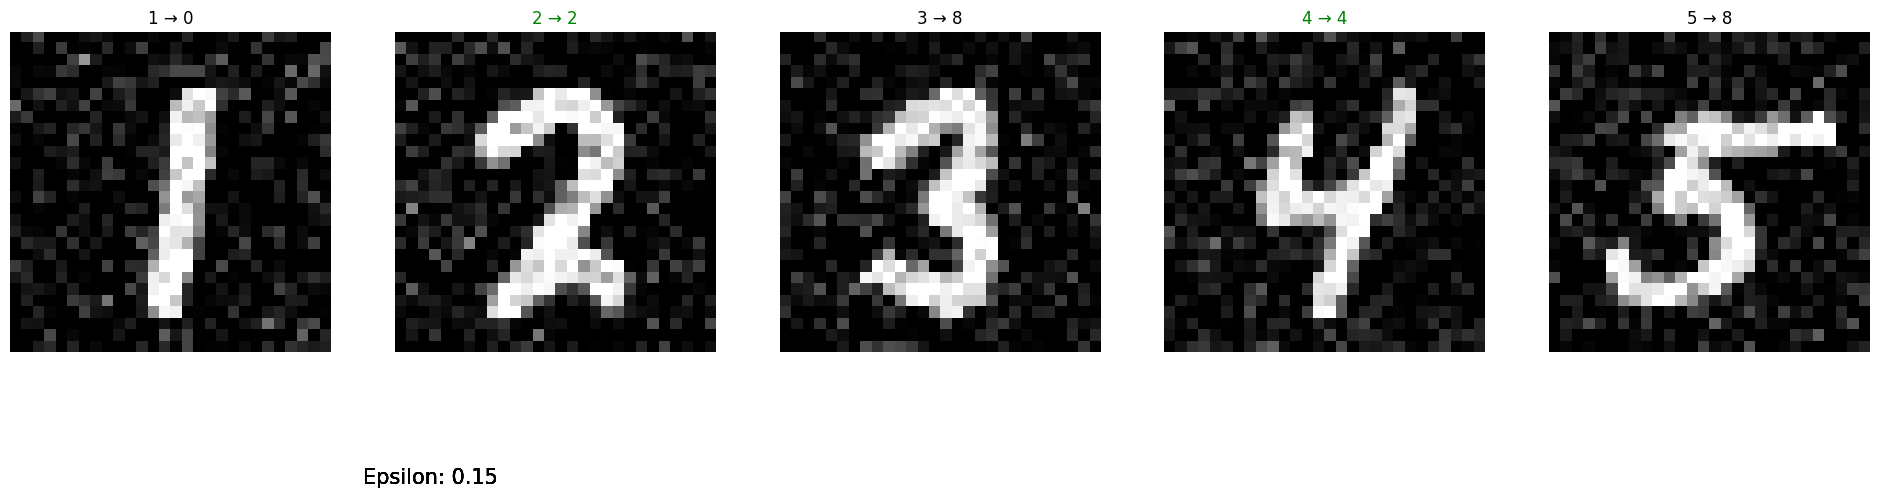

Accuracy: 15.60%


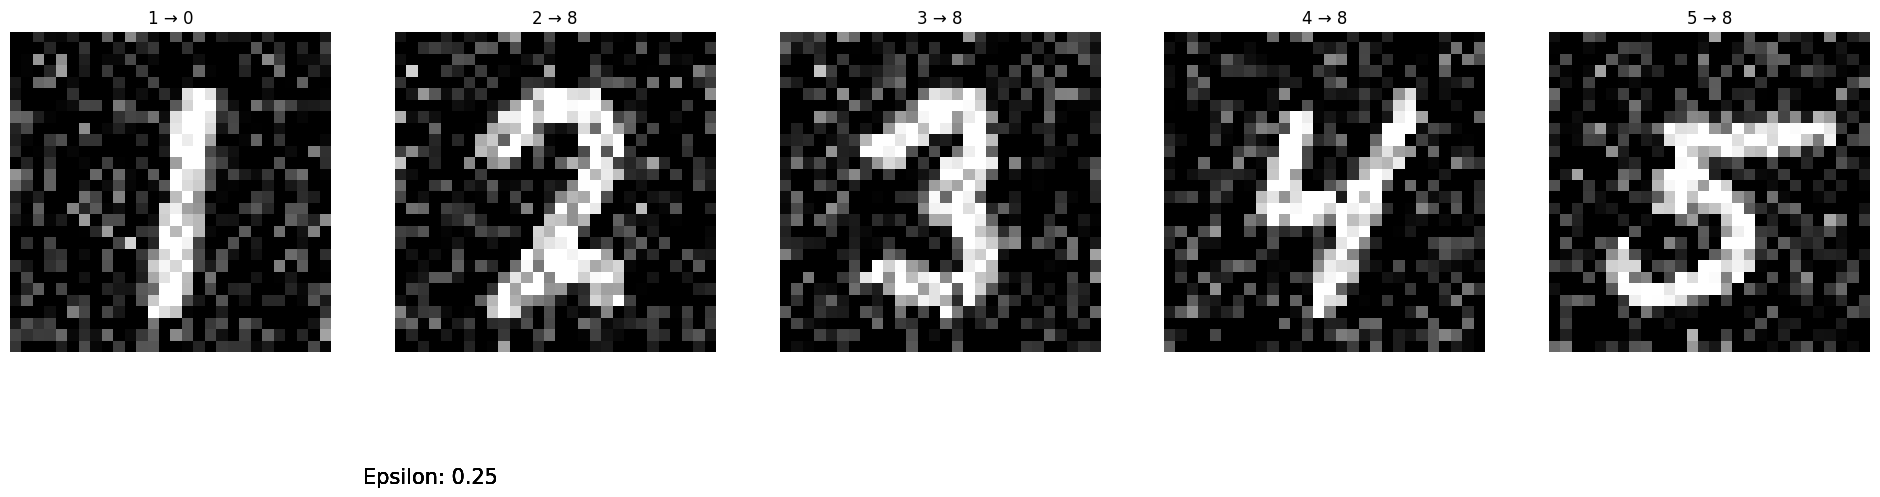

Accuracy: 10.09%


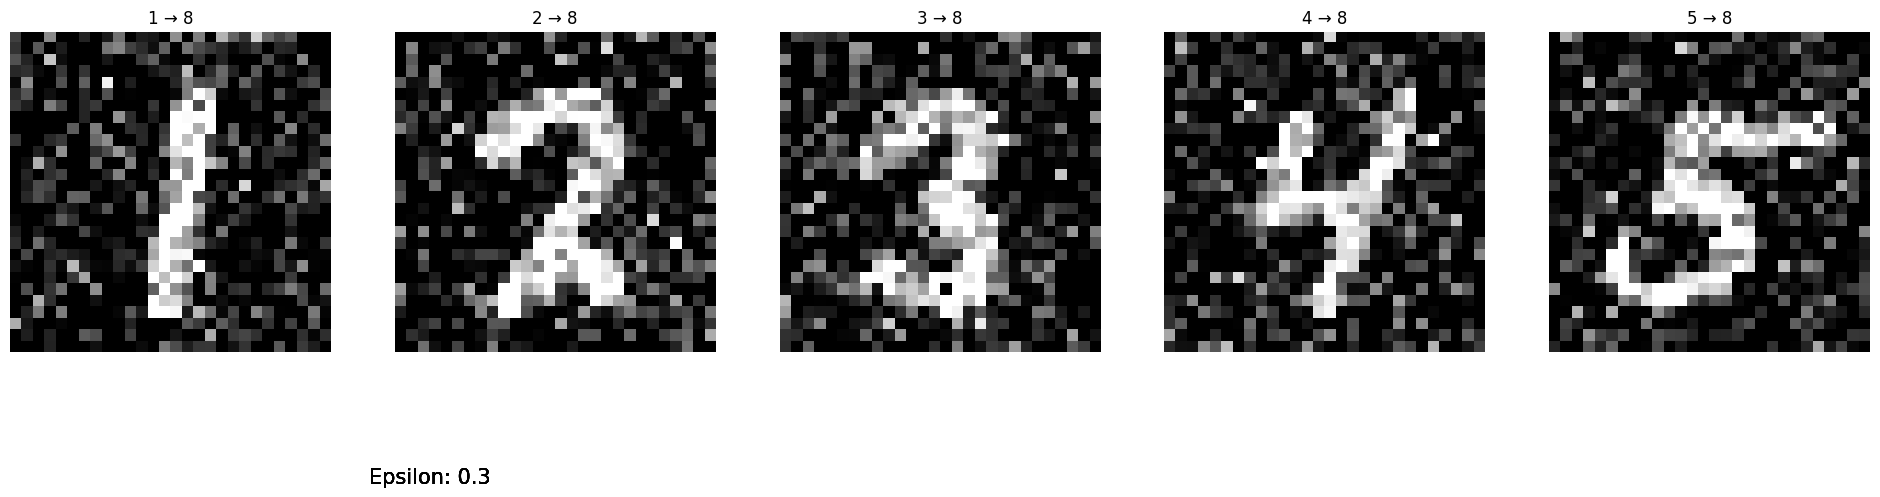

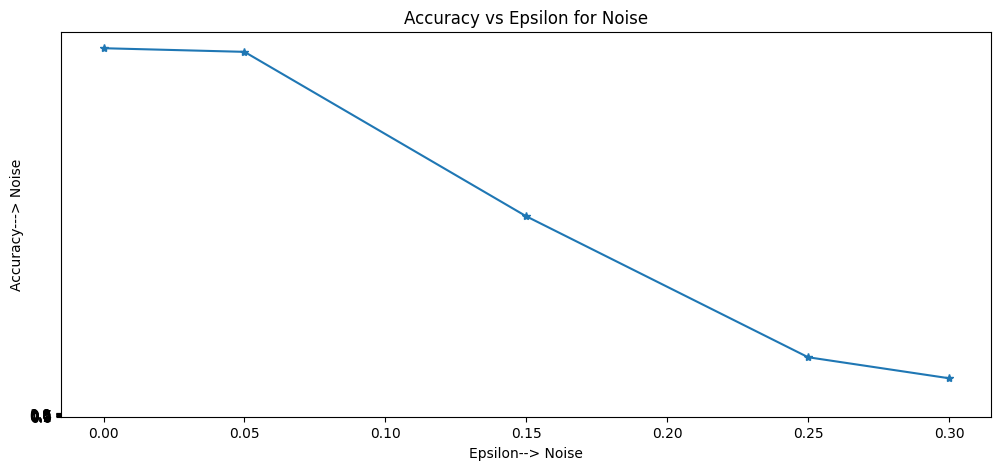

In [16]:
#noise attack
noise_accs = []
noise_adv_exs = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epsilons = [0, .05, .15, .25, .3]
criterion = nn.CrossEntropyLoss()
for epsilon in epsilons:
  acc,adv_img, n_pred, adv_pred, img_noise = noise_attack(test_data, epsilon)
  noise_accs.append(acc)
  visualize_side_by_side(adv_img.detach(), n_pred.detach(), adv_pred.detach(),epsilon)
plot_accs(noise_accs, "Noise")

# visualize_feature_maps(model, img_noise, device)
# visualize_feature_maps(model,adv_img[0].unsqueeze(0), device)

In [1]:
# PGD parameters - focused on step size tuning
pgd_accs = []
step_size_results = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fixed parameters
epsilon = 0.03
iters = 20

# Parameter to tune
step_sizes = [0.01, 0.04,0.32]
criterion = nn.CrossEntropyLoss()

# Step size tuning loop
for step_size in step_sizes:
    print(f"Testing step size: {step_size}")

    acc, adv_img, n_pred, adv_pred ,img_pgm= pgd_attack(
        model,
        criterion,
        test_data,
        epsilon=epsilon,
        step_size=step_size,
        iters=iters
    )

    pgd_accs.append(acc)
    step_size_results[step_size] = acc

    # Visualize examples for this step size
    visualize_side_by_side(adv_img.detach(), n_pred.detach(), adv_pred.detach(), f"ε={epsilon}, step={step_size}")
# visualize_feature_maps(model, img_pgm, device)
# visualize_feature_maps(model,adv_img[2].unsqueeze(0), device)